In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook

# Load ACL training data.
train_acl = pd.read_csv('../content/drive/MyDrive/MRNet-v1.0/train-acl.csv', header=None,
                        names=['Case', 'Abnormal'], dtype={'Case': str, 'Abnormal': np.int64})

train_acl.head()


,Case,Abnormal
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


#data processing

In [5]:
print(train_acl.shape)
# (1130, 2)

(1130, 2)


In [6]:
train_acl.Abnormal.value_counts(normalize=True)  # Calculates the proportion of each unique value in the 'Abnormal' column.


,proportion
Abnormal,
0,0.815929
1,0.184071


In [7]:
case = '0000'

mri_axial = np.load('../content/drive/MyDrive/MRNet-v1.0/train/axial/1130.npy')


print(f'MRI scan on axial plane: {mri_axial.shape}')


MRI scan on axial plane: (25, 256, 256)


Text(0.5, 1.0, 'Case 0 | Slice 1 | Axial')

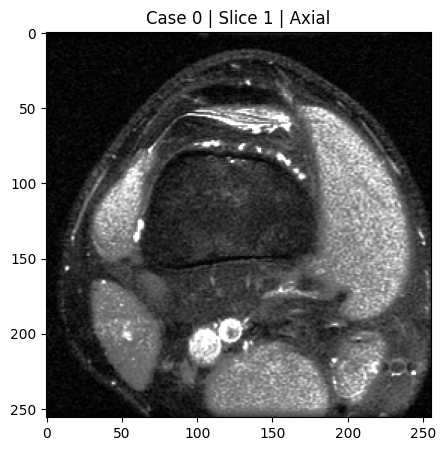

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))  # Single plot.

ax.imshow(mri_axial[0, :, :], 'gray')  # Display image in grayscale.
ax.set_title('Case 0 | Slice 1 | Axial')


In [14]:
train_path = '../content/drive/MyDrive/MRNet-v1.0/train/'

def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}/{}/{}.npy'.format(data_path, plane, case)  # Construct file path
    return np.load(fpath)  # Load and return data

def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']  # Define planes
    for plane in planes:
        x[plane] = load_one_stack(case, plane=plane)  # Load data for each plane
    return x

def load_cases(train=True, n=None):
    assert (type(n) == int) and (n < 1250)  # Validate n

    # Load case list based on train or validation mode
    case_list = pd.read_csv(
        '../content/drive/MyDrive/MRNet-v1.0/{}-acl.csv'.format('train' if train else 'valid'),
        names=['case', 'label'], header=None, dtype={'case': str, 'label': np.int64}
    )['case'].tolist()

    if n is not None:
        case_list = case_list[:n]  # Subset case list

    cases = {}
    for case in tqdm_notebook(case_list, leave=False):  # Iterate through cases
        cases[case] = load_stacks(case)  # Load stacks for each case
    return cases

cases = load_cases(n=100)  # Load 100 cases


<ipython-input-14-504510c39ef0>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for case in tqdm_notebook(case_list, leave=False):  # Iterate through cases


  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
print(cases['0000'].keys())

dict_keys(['coronal', 'sagittal', 'axial'])


In [16]:
print(cases['0000']['axial'].shape)
print(cases['0000']['coronal'].shape)
print(cases['0000']['sagittal'].shape)

(44, 256, 256)
(36, 256, 256)
(36, 256, 256)


In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from sklearn.preprocessing import normalize
import gc
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras.layers import Dropout
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
K.set_image_data_format("channels_last")

In [ ]:
def trainingSet(file_name):
    training_set = []  # Initialize an empty list to store the training data

    # Iterate through sorted .npy files in the specified directory
    for np_name in sorted(glob.glob('../content/drive/MyDrive/MRNet-v1.0/train/' + file_name + '/*.npy')):
        training_set.append(np.load(np_name))  # Load each .npy file and append it to the list

    return training_set  # Return the list of loaded data


In [ ]:
def load_labels(train_file_name):
    # Load labels from a CSV file, ignoring the first column
    training_labels = np.loadtxt(train_file_name, delimiter=',')[:,1]
    return training_labels  # Return the loaded labels


In [ ]:

#extract the middle 3 slices as most of the time they deside if the patiant has a certain tear or not
def extract_3(dataset, data_size):
    for i in range(len(dataset)):
        dataset[i] = list(dataset[i])
        middel_idx = int(len(dataset[i]) / 2)
        dataset[i] = dataset[i][middel_idx - 1 : middel_idx + 2]
        dataset[i] = np.array(dataset[i])
    dataset = np.array(dataset)
    dataset = dataset.reshape(data_size, 256, 256 ,3)
    return dataset

In [ ]:
#load the training data for each angle of the knee
training_set_axial= trainingSet('axial')

In [ ]:
training_set_coronal=trainingSet('coronal')

In [ ]:
training_set_sagittal=trainingSet('sagittal')

In [ ]:
#extract the middel 3 slices from each stack
training_set_axial = extract_3(training_set_axial, 1130)
training_set_coronal =extract_3(training_set_coronal, 1130)
training_set_sagittal =extract_3(training_set_sagittal, 1130)

In [ ]:
#load the labels of the trainig data for each knee tear
training_label_abnormal = load_labels('../content/drive/MyDrive/MRNet-v1.0/train-abnormal.csv')
training_label_acl = load_labels('../content/drive/MyDrive/MRNet-v1.0/train-acl.csv')
training_label_meniscus = load_labels('../content/drive/MyDrive/MRNet-v1.0/train-meniscus.csv')

In [18]:
datagen = ImageDataGenerator(
    rotation_range=5,  # Random rotation
    width_shift_range=0.05,  # Random horizontal shift
    height_shift_range=0.05,  # Random vertical shift
    zoom_range=0.01,  # Random zoom
    fill_mode='nearest'  # Nearest pixel for data augmentation
)


In [ ]:
def data_augmentation(dataset, labels):
    augmented_data = []  # List to store augmented images
    augmented_labels = []  # List to store corresponding augmented labels
    num_augmented = 0  # Counter for the number of augmented samples

    # Apply data augmentation to the dataset
    for X_batch, y_batch in datagen.flow(dataset, labels, batch_size=dataset.shape[0], shuffle=False):
        augmented_data.append(X_batch)  # Append augmented images
        augmented_labels.append(y_batch)  # Append corresponding augmented labels
        num_augmented += dataset.shape[0]  # Increment the counter

        # Break when twice the original dataset has been augmented
        if num_augmented == dataset.shape[0] * 2:
            break

    # Convert lists to numpy arrays and reshape
    dataset = np.array(augmented_data).reshape(num_augmented, 256, 256, 3)
    labels = np.array(augmented_labels).reshape(num_augmented, 1)

    return dataset, labels  # Return the augmented dataset and labels


In [ ]:
#apply augmentations
training_set_axial, training_label_abnormal = data_augmentation(training_set_axial, training_label_abnormal)
training_set_coronal, training_label_acl = data_augmentation(training_set_coronal, training_label_acl)
training_set_sagittal, training_label_meniscus = data_augmentation(training_set_sagittal, training_label_meniscus)
training_set_axial.shape

(4520, 256, 256, 3)

# Inception v3

In [ ]:
# Load InceptionV3 pre-trained model from Keras without the top layer
# Specify the shape of the input image as (256x256x3)
mri_InceptionV3 = InceptionV3(include_top=False, input_shape=(256, 256, 3))  # Uses ImageNet by default

# Remove the last layer
mri_InceptionV3.layers.pop()

# Get the output of the InceptionV3 model ("feature extraction")
mri_InceptionV3_output = mri_InceptionV3.output

# Add a GlobalMaxPooling2D layer
mri_InceptionV3_last_layer = GlobalMaxPooling2D()(mri_InceptionV3_output)

# Add Dense layers for classification
mri_InceptionV3_last_layer = Dense(1024, activation='relu')(mri_InceptionV3_last_layer)
mri_InceptionV3_last_layer = Dense(128, activation='relu')(mri_InceptionV3_last_layer)
mri_InceptionV3_last_layer = Dense(32, activation='relu')(mri_InceptionV3_last_layer)

# Add a final Dense layer with a sigmoid activation for binary classification
predictor = Dense(1, activation='sigmoid')(mri_InceptionV3_last_layer)

# Create the modified model
modified_mri_InceptionV3 = Model(inputs=mri_InceptionV3.input, outputs=predictor)

# Display the model summary
modified_mri_InceptionV3.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 127, 127, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 127, 127, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 125, 125, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 125, 125, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 125, 125, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 125, 125, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 125, 125, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 62, 62, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 62, 62, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 62, 62, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 60, 60, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 24,036,321 (91.69 MB)

 Trainable params: 24,001,889 (91.56 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# Freeze added dense layers and unfreeze the rest
for layer in modified_mri_InceptionV3.layers[15:]:
    layer.trainable = True

for layer in mri_InceptionV3.layers:
    layer.trainable = False

# Compile the modified model
modified_mri_InceptionV3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])


In [ ]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []  # Initialize F1 score list

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()  # Predict on validation data
        val_targ = self.validation_data[1]  # True labels
        _val_f1 = f1_score(val_targ, val_predict)  # Calculate F1 score
        self.val_f1s.append(_val_f1)  # Append F1 score
        print('-val_f1 : %f ' % (_val_f1))
        return

metrics = Metrics()


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow

class Metrics(tensorflow.keras.callbacks.Callback):
    def __init__(self, val_x, val_y, batch_size=20):
        super().__init__()
        self.val_x = val_x  # Validation features
        self.val_y = val_y  # Validation labels
        self.batch_size = batch_size  # Batch size for predictions

    def on_train_begin(self, logs=None):
        self.confusion = []  # List to store confusion matrices
        self.precision = []  # List to store precision values
        self.recall = []  # List to store recall values
        self.f1s = []  # List to store F1 scores

    def on_epoch_end(self, epoch, logs=None):
        x = self.val_x  # Validation features
        targ = self.val_y  # True labels

        # Predict on validation set
        score = np.asarray(self.model.predict(x))
        predict = np.round(np.asarray(self.model.predict(x)))

        # Compute F1 score and confusion matrix
        self.f1s.append(f1_score(targ, predict, average='micro'))
        self.confusion.append(confusion_matrix(targ.argmax(axis=1), predict.argmax(axis=1)))

        # Print results at the end of each epoch
        print("\nAt epoch {} f1_score {}:".format(epoch, self.f1s[-1]))
        print('\nAt epoch {} cm {}'.format(epoch, self.confusion[-1]))
        return


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from sklearn.preprocessing import normalize
import gc
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras.layers import Dropout
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns # Import seaborn

K.set_image_data_format("channels_last")

def plot_history(history):
    plt.figure(figsize=(8, 6))  # Set figure size
    ax = plt.gca()  # Get the current axis
    plt.title('Training performance')  # Plot title
    plt.plot(history.epoch, history.history['loss'], label='Loss')  # Training loss
    plt.plot(history.epoch, history.history['val_loss'], label='Validation Error')  # Validation loss
    plt.plot(history.epoch, history.history['accuracy'], label='Accuracy')  # Training accuracy
    plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy
    plt.plot(metrics.val_f1s, label='F1 Score')  # F1 Score

    plt.grid(True, color='white')  # Add grid to plot

    # Apply seaborn style for aesthetics
    sns.set_style('darkgrid')

    plt.legend()  # Display legend


In [ ]:
#save the model that has the max validation accuracy
#at the end plot the trainng loss & accuracy, validation loss & accuracy & F-score
def fit_model(training_set, training_labels, model_file_name):

    history = modified_mri_InceptionV3.fit(x = training_set, y = training_labels, batch_size=32,
                       epochs=30, validation_split = 0.05,
                       callbacks =[
                          EarlyStopping(patience=3, monitor = 'val_loss', mode = 'max'),
                          ModelCheckpoint(model_file_name + '.keras', monitor='val_accuracy', save_best_only=True, mode='max', save_freq='epoch')]) # Change 'period' to 'save_freq='epoch'' to save every epoch
    plot_history(history)
    best_model = load_model(model_file_name +'.keras')
    return best_model

Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 71s 527ms/step - accuracy: 0.8665 - loss: 0.2964 - val_accuracy: 0.8407 - val_loss: 0.3584
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 71s 526ms/step - accuracy: 0.9005 - loss: 0.2332 - val_accuracy: 0.8540 - val_loss: 0.3236
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 70s 518ms/step - accuracy: 0.8751 - loss: 0.2923 - val_accuracy: 0.7876 - val_loss: 0.3875
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 70s 517ms/step - accuracy: 0.8922 - loss: 0.2561 - val_accuracy: 0.8496 - val_loss: 0.3770
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 70s 519ms/step - accuracy: 0.8818 - loss: 0.2719 - val_accuracy: 0.7876 - val_loss: 0.4305


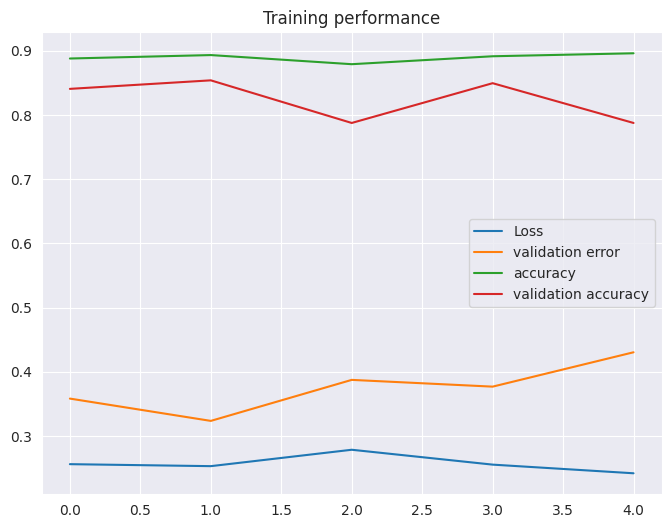

In [ ]:
axial_abnormal_model = fit_model(training_set_axial, training_label_abnormal, "./axial_abnormal_model")


#InceptionResNetV2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

# Set image data format
K.set_image_data_format("channels_last")

# Load InceptionResNetV2 pre-trained model from keras without the top layer
mri_InceptionResNetV2 = InceptionResNetV2(include_top=False, input_shape=(256, 256, 3))

# Get the output and add Dense layers
mri_InceptionResNetV2_output = mri_InceptionResNetV2.output
mri_InceptionResNetV2_last_layer = GlobalMaxPooling2D()(mri_InceptionResNetV2_output)
mri_InceptionResNetV2_last_layer = Dense(1024, activation='relu')(mri_InceptionResNetV2_last_layer)
mri_InceptionResNetV2_last_layer = Dense(128, activation='relu')(mri_InceptionResNetV2_last_layer)
mri_InceptionResNetV2_last_layer = Dense(32, activation='relu')(mri_InceptionResNetV2_last_layer)

predictor = Dense(1, activation='sigmoid')(mri_InceptionResNetV2_last_layer)

# Create the modified model
modified_mri_InceptionResNetV2 = Model(inputs=mri_InceptionResNetV2.input, outputs=predictor)

# Freeze layers and compile the model
for layer in modified_mri_InceptionResNetV2.layers[15:]:
    layer.trainable = True
for layer in mri_InceptionResNetV2.layers:
    layer.trainable = False

modified_mri_InceptionResNetV2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Display the summary
modified_mri_InceptionResNetV2.summary()

# Custom callback for metrics
class Metrics(Callback):
    def __init__(self, val_x, val_y, batch_size=20):
        super().__init__()
        self.val_x = val_x
        self.val_y = val_y
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.f1s = []

    def on_epoch_end(self, epoch, logs=None):
        x = self.val_x
        targ = self.val_y
        score = np.asarray(self.model.predict(x, batch_size=self.batch_size))
        predict = np.round(score)
        self.f1s.append(f1_score(targ, predict, average='micro'))
        print(f"\nAt epoch {epoch} F1-score: {self.f1s[-1]:.4f}")

# Instantiate the custom metrics callback
metrics = Metrics(val_x=training_set_axial, val_y=training_label_acl)

# Callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

# Define fit_model
def fit_model(training_set, training_labels, model_file_name):
    history = modified_mri_InceptionResNetV2.fit(
        x=training_set,
        y=training_labels,
        batch_size=32,
        epochs=30,
        validation_split=0.05,
        callbacks=[
            EarlyStopping(patience=3, monitor='val_loss', mode='min'),
            ModelCheckpoint(model_file_name + '.keras', monitor='val_accuracy', save_best_only=True, mode='max', save_freq='epoch')
        ]
    )
    plot_history(history)
    best_model = load_model(model_file_name + '.keras')
    return best model

# Plot training performance
def plot_history(history):
    plt.figure(figsize=(8, 6))
    sns.set_style('darkgrid')
    plt.title('Training performance')
    plt.plot(history.epoch, history.history['loss'], label='Loss')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
    plt.plot(history.epoch, history.history['accuracy'], label='Accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
    if hasattr(metrics, 'f1s'):
        plt.plot(metrics.f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True, color='white')
    plt.show()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2530 (Conv2D)      │ (None, 127, 127, 32)   │            864 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2530  │ (None, 127, 127, 32)   │             96 │ conv2d_2530[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2530           │ (None, 127, 127, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2531 (Conv2D)      │ (None, 125, 125, 32)   │          9,216 │ activation_2530[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2531  │ (None, 125, 125, 32)   │             96 │ conv2d_2531[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2531           │ (None, 125, 125, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2532 (Conv2D)      │ (None, 125, 125, 64)   │         18,432 │ activation_2531[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2532  │ (None, 125, 125, 64)   │            192 │ conv2d_2532[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2532           │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_52          │ (None, 62, 62, 64)     │              0 │ activation_2532[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2533 (Conv2D)      │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d_52[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2533  │ (None, 62, 62, 80)     │            240 │ conv2d_2533[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2533           │ (None, 62, 62, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2534 (Conv2D) 

 Total params: 56,045,985 (213.80 MB)

 Trainable params: 1,709,249 (6.52 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6893 - loss: 43.5451 - val_accuracy: 0.3518 - val_loss: 2.0201
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.6972 - loss: 1.5282 - val_accuracy: 0.8164 - val_loss: 0.7892
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.7385 - loss: 2.1128 - val_accuracy: 0.8230 - val_loss: 1.5375
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7320 - loss: 1.8078 - val_accuracy: 0.8230 - val_loss: 4.3726
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7225 - loss: 2.4022 - val_accuracy: 0.8252 - val_loss: 0.9602


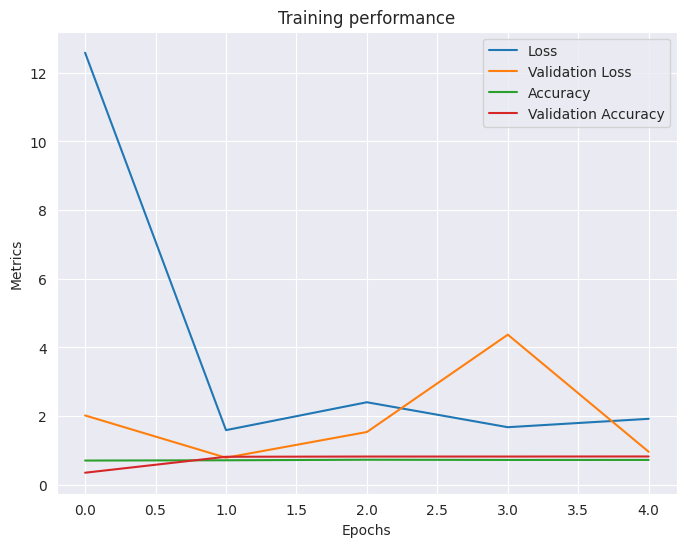

In [ ]:
axial_abnormal_model = fit_model(training_set_axial, training_label_acl, "./axial_acl_model")


# Efficient Net

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0  # Consider a smaller variant
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set image data format (assuming channels last)
tf.keras.backend.set_image_data_format("channels_last")

# Load EfficientNetB0 pre-trained model without the top layer
efficientnet_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Get the output of the EfficientNetB0 model
efficientnet_output = efficientnet_model.output

# Add a single Dense layer for classification
last_layer = GlobalAveragePooling2D()(efficientnet_output)
last_layer = Dense(1, activation='sigmoid')(last_layer)

# Create the modified model
modified_efficientnet_model = Model(inputs=efficientnet_model.input, outputs=last_layer)

# Freeze the pre-trained EfficientNetB0 layers and fine-tune the top layer
for layer in modified_efficientnet_model.layers[:-1]:
    layer.trainable = False

modified_efficientnet_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

modified_efficientnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:

# Define a custom callback for tracking F1 score, precision, recall, and confusion matrix
class Metrics(Callback):
    def __init__(self, val_x, val_y, batch_size=20):
        super().__init__()
        self.val_x = val_x
        self.val_y = val_y
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []

    def on_epoch_end(self, epoch, logs=None):
        x = self.val_x
        targ = self.val_y

        score = np.asarray(self.model.predict(x, batch_size=self.batch_size))
        predict = np.round(score)

        _f1 = f1_score(targ, predict, average='micro')
        cm = confusion_matrix(targ.argmax(axis=1), predict.argmax(axis=1))

        self.f1s.append(_f1)
        self.confusion.append(cm)

        print(f"\nAt epoch {epoch} F1-score: {_f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        return

# Instantiate the custom metrics callback
metrics = Metrics(val_x=training_set_axial, val_y=training_label_acl)

# Add early stopping and model checkpoint callbacks
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Define the fit_model function for training and evaluation
def fit_model(training_set, training_labels, model_file_name):
    history = modified_efficientnet_model.fit(
        x=training_set,
        y=training_labels,
        batch_size=32,
        epochs=30,
        validation_split=0.10,
        callbacks=[
            EarlyStopping(patience=3, monitor='val_loss', mode='min'),
            ModelCheckpoint(model_file_name + '.keras', monitor='val_accuracy', save_best_only=True, mode='max', save_freq='epoch')
        ]
    )
    plot_history(history)
    best_model = load_model(model_file_name + '.keras')


    return best_model

# Plot training performance
def plot_history(history):
    plt.figure(figsize=(8, 6))
    sns.set_style('darkgrid')
    plt.title('Training performance')
    plt.plot(history.epoch, history.history['loss'], label='Loss')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
    plt.plot(history.epoch, history.history['accuracy'], label='Accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
    if hasattr(metrics, 'f1s'):
        plt.plot(metrics.f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True, color='white')
    plt.show()


Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 57s 376ms/step - accuracy: 0.5700 - loss: 0.6724 - val_accuracy: 0.8230 - val_loss: 0.4793
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 45s 353ms/step - accuracy: 0.8206 - loss: 0.4718 - val_accuracy: 0.8230 - val_loss: 0.4565
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.8199 - loss: 0.4585 - val_accuracy: 0.8230 - val_loss: 0.4426
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.8212 - loss: 0.4481 - val_accuracy: 0.8230 - val_loss: 0.4336
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 357ms/step - accuracy: 0.8178 - loss: 0.4383 - val_accuracy: 0.8252 - val_loss: 0.4270
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 358ms/step - accuracy: 0.8211 - loss: 0.4348 - val_accuracy: 0.8274 - val_loss: 0.4213
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 45s 355ms/step - accuracy: 0.8122 - loss: 0.4336 - val_accuracy: 0.8274 - val_loss: 0.4170
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.8215 - loss: 0

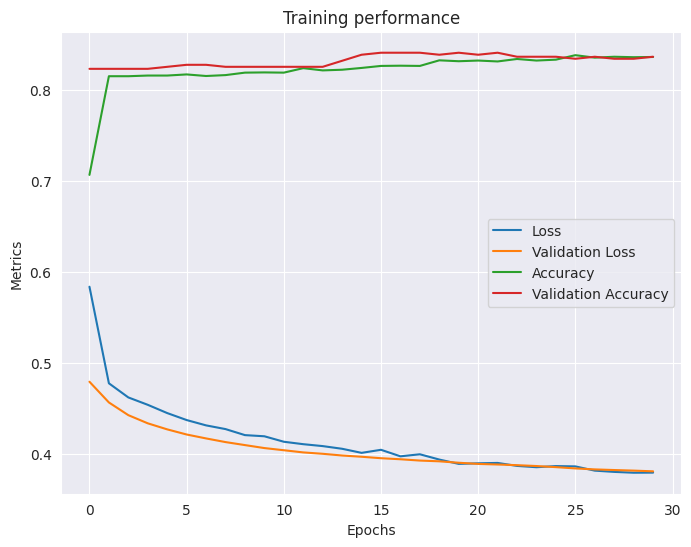

In [ ]:
axial_abnormal_model = fit_model(training_set_axial, training_label_acl, "./axial_acl_model")

#Efficient Net Unfrozen

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0  # Consider a smaller variant
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set image data format (assuming channels last)
tf.keras.backend.set_image_data_format("channels_last")

# Load EfficientNetB0 pre-trained model without the top layer
efficientnet_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Get the output of the EfficientNetB0 model
efficientnet_output = efficientnet_model.output

# Add a single Dense layer for classification
last_layer = GlobalAveragePooling2D()(efficientnet_output)
last_layer = Dense(1, activation='sigmoid')(last_layer)

# Create the modified model
modified_efficientnet_model = Model(inputs=efficientnet_model.input, outputs=last_layer)

# Freeze the pre-trained EfficientNetB0 layers and fine-tune the top layer
#for layer in modified_efficientnet_model.layers[:-1]:
   # layer.trainable = False

modified_efficientnet_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

modified_efficientnet_model.summary()

# Define a custom callback for tracking F1 score, precision, recall, and confusion matrix
class Metrics(Callback):
    def __init__(self, val_x, val_y, batch_size=20):
        super().__init__()
        self.val_x = val_x
        self.val_y = val_y
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []

    def on_epoch_end(self, epoch, logs=None):
        x = self.val_x
        targ = self.val_y

        score = np.asarray(self.model.predict(x, batch_size=self.batch_size))
        predict = np.round(score)

        _f1 = f1_score(targ, predict, average='micro')
        cm = confusion_matrix(targ.argmax(axis=1), predict.argmax(axis=1))

        self.f1s.append(_f1)
        self.confusion.append(cm)

        print(f"\nAt epoch {epoch} F1-score: {_f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        return

# Instantiate the custom metrics callback
metrics = Metrics(val_x=training_set_axial, val_y=training_label_acl)

# Add early stopping and model checkpoint callbacks
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Define the fit_model function for training and evaluation
def fit_model(training_set, training_labels, model_file_name):
    history = modified_efficientnet_model.fit(
        x=training_set,
        y=training_labels,
        batch_size=32,
        epochs=30,
        validation_split=0.10,
        callbacks=[
            EarlyStopping(patience=3, monitor='val_loss', mode='min'),
            ModelCheckpoint(model_file_name + '.keras', monitor='val_accuracy', save_best_only=True, mode='max', save_freq='epoch')
        ]
    )
    plot_history(history)
    best_model = load_model(model_file_name + '.keras')


    return best_model

# Plot training performance
def plot_history(history):
    plt.figure(figsize=(8, 6))
    sns.set_style('darkgrid')
    plt.title('Training performance')
    plt.plot(history.epoch, history.history['loss'], label='Loss')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
    plt.plot(history.epoch, history.history['accuracy'], label='Accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
    if hasattr(metrics, 'f1s'):
        plt.plot(metrics.f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True, color='white')
    plt.show()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

NameError: name 'Callback' is not defined

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.7134 - loss: 2.3875 - val_accuracy: 0.8230 - val_loss: 1.7972
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7179 - loss: 2.0898 - val_accuracy: 0.8230 - val_loss: 2.1733
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7441 - loss: 1.5368 - val_accuracy: 0.8230 - val_loss: 1.2181
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.6927 - loss: 3.5913 - val_accuracy: 0.8230 - val_loss: 1.4199
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7054 - loss: 2.7572 - val_accuracy: 0.1770 - val_loss: 2.8234
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.6890 - loss: 1.2193 - val_accuracy: 0.8230 - val_loss: 0.8710
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7459 - loss: 0.8482 - val_accuracy: 0.8230 - val_loss: 1.3401
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.7691 - loss: 0.7759 - val_accu

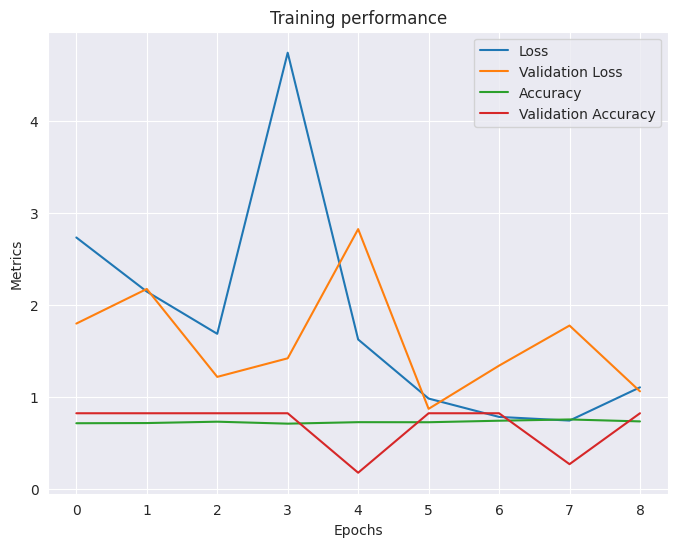

In [ ]:
axial_abnormal_model = fit_model(training_set_axial, training_label_acl, "./axial_acl_model")